In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [2]:

from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
path.ls()
(path/"images").ls()
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/Users/nikhil/Portfolio/pet-breed-classifier/env/lib/python3.11/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715184404505/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


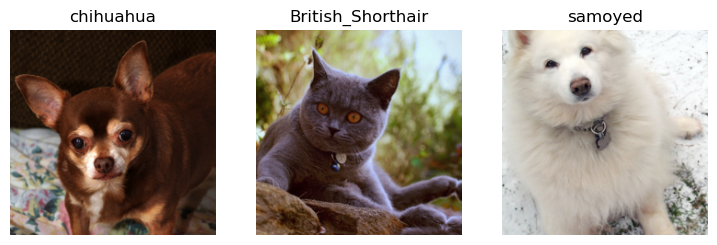

In [4]:
dls.show_batch(nrows=1,ncols=3)

In [6]:
#Fine tuning the model


learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes.